## Performance of Equal Weighted Portfolio
### Import Packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
import statsmodels.api as sm
import statistics
import sys
sys.path.insert(0, "../")
import util
from importlib import reload
util=reload(util)

### Set Local Macro Variables

In [2]:
start = 2010

### Import Data
#### Equal Weighted Sample Portfolio

In [3]:
port = pd.read_csv('ew_sample_port.csv.gz', compression='gzip', usecols=lambda x: x.lower())

port['jdate'] = pd.to_datetime(port['jdate'])

port.head()

,jdate,ewret,ewret10
0,2000-12-31,-0.208019,-0.235841
1,2001-12-31,-0.134308,-0.127462
2,2002-12-31,-0.507991,-0.543793
3,2003-12-31,1.142871,0.975398
4,2004-12-31,0.150138,0.072438


In [4]:
port['year'] = port['jdate'].dt.year

#### S&P 500

In [5]:
crsp_sp = pd.read_csv('qcrsp500d_raw.csv.gz', compression='gzip', usecols=lambda x: x.lower())

crsp_sp = crsp_sp.rename(columns={'caldt':'date'})
crsp_sp['date'] = pd.to_datetime(crsp_sp['date'])

crsp_sp.head()

,date,vwretd,vwretx,ewretd,ewretx,totval,totcnt,usdval,usdcnt,spindx,sprtrn
0,1925-12-31,NaN,NaN,NaN,NaN,15236829.5,89.0,NaN,NaN,NaN,NaN
1,1926-01-02,0.004297,0.004297,0.002941,0.002941,15319686.5,89.0,15236829.5,79.0,NaN,NaN
2,1926-01-04,-0.001357,-0.001357,0.001036,0.001036,15298901.2,89.0,15319686.5,80.0,NaN,NaN
3,1926-01-05,-0.004603,-0.004653,-0.005856,-0.006063,15227711.5,89.0,15298901.2,80.0,NaN,NaN
4,1926-01-06,0.000537,0.000537,0.000888,0.000888,15235889.2,89.0,15227711.5,80.0,NaN,NaN


In [6]:
# Annual S&P 500 Returns
df = crsp_sp
df = df.sort_values(['date'],ascending=True)
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day
df['1+sprtrn']=df['sprtrn']+1
df['annRet'] = df.groupby(['year'])['1+sprtrn'].cumprod()-1
df = df[df['month']==12]
#df = df[df['day']==31]
crsp_sp = df

crsp_sp.head()

,date,vwretd,vwretx,ewretd,ewretx,totval,totcnt,usdval,usdcnt,spindx,sprtrn,month,year,day,1+sprtrn,annRet
0,1925-12-31,NaN,NaN,NaN,NaN,15236829.5,89.0,NaN,NaN,NaN,NaN,12,1925,31,NaN,NaN
274,1926-12-01,0.002556,0.001625,0.002951,0.002112,16994146.9,89.0,16907546.6,84.0,NaN,NaN,12,1926,1,NaN,NaN
275,1926-12-02,0.004838,0.004838,0.004315,0.004315,17016954.5,89.0,16935021.9,84.0,NaN,NaN,12,1926,2,NaN,NaN
276,1926-12-03,0.002793,0.001962,0.002165,0.001465,17050356.9,89.0,17016954.5,84.0,NaN,NaN,12,1926,3,NaN,NaN
277,1926-12-04,-0.001293,-0.001293,-0.001505,-0.001505,17028312.9,89.0,17050356.9,84.0,NaN,NaN,12,1926,4,NaN,NaN


In [7]:
annRet_sp =pd.DataFrame(columns=['year','sp_ret'])

for y in range (start,2021):
     annRet_sp = annRet_sp.append({'year':y,
                                   'sp_ret':crsp_sp.loc[(crsp_sp['year'] == y),'annRet'].values[-1]
                                  },
                                   ignore_index=True)
annRet_sp.head()

,year,sp_ret
0,2010.0,0.127827
1,2011.0,-0.000032
2,2012.0,0.134057
3,2013.0,0.296013
4,2014.0,0.113906


In [8]:
perf = pd.merge(annRet_sp,port,'left','year').drop(columns = ['jdate'])

perf.head()

,year,sp_ret,ewret,ewret10
0,2010.0,0.127827,0.409816,0.348942
1,2011.0,-0.000032,-0.130877,-0.123921
2,2012.0,0.134057,0.220315,0.180448
3,2013.0,0.296013,0.516071,0.464875
4,2014.0,0.113906,0.098047,0.103425


In [9]:
perf.columns = (['year','sp_ret','port_ret', 'port_ret10'])

In [10]:
# Calculate cumulative returns
perf['1+sp_ret'] = perf['sp_ret']+1
perf['1+port_ret'] = perf['port_ret']+1
perf['1+port_ret10'] = perf['port_ret10']+1
perf['total_sp_ret'] = (perf['1+sp_ret'].cumprod()-1)*100
perf['total_port_ret'] = (perf['1+port_ret'].cumprod()-1)*100
perf['total_port_ret10'] = (perf['1+port_ret10'].cumprod()-1)*100
perf['total_sp_ret'] = ((perf['1+sp_ret'].cumprod()-1)*100).round(3)
perf['total_port_ret'] = ((perf['1+port_ret'].cumprod()-1)*100).round(3)

In [11]:
perf['ab_ret']=perf['port_ret']-perf['sp_ret']
perf['ab_ret10']=perf['port_ret10']-perf['sp_ret']

perf.head()

,year,sp_ret,port_ret,port_ret10,1+sp_ret,1+port_ret,1+port_ret10,total_sp_ret,total_port_ret,total_port_ret10,ab_ret,ab_ret10
0,2010.0,0.127827,0.409816,0.348942,1.127827,1.409816,1.348942,12.783,40.982,34.894168,0.281989,0.221115
1,2011.0,-0.000032,-0.130877,-0.123921,0.999968,0.869123,0.876079,12.779,22.530,18.177947,-0.130845,-0.123889
2,2012.0,0.134057,0.220315,0.180448,1.134057,1.220315,1.180448,27.898,49.526,39.502940,0.086258,0.046391
3,2013.0,0.296013,0.516071,0.464875,1.296013,1.516071,1.464875,65.757,126.691,104.354426,0.220058,0.168863
4,2014.0,0.113906,0.098047,0.103425,1.113906,1.098047,1.103425,84.638,148.918,125.489687,-0.015860,-0.010482


### Plot Portfolio Performance

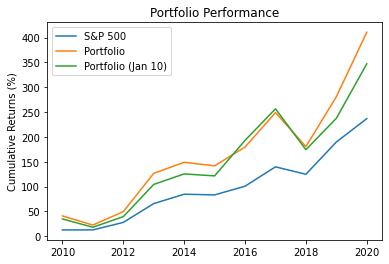

In [12]:
plt.plot(perf['year'],perf['total_sp_ret'],label = 'S&P 500')
plt.plot(perf['year'],perf['total_port_ret'],label = 'Portfolio')
plt.plot(perf['year'],perf['total_port_ret10'],label = 'Portfolio (Jan 10)')
plt.legend()
#plt.yscale('log')
plt.ylabel('Cumulative Returns (%)')
plt.title('Portfolio Performance')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.show()

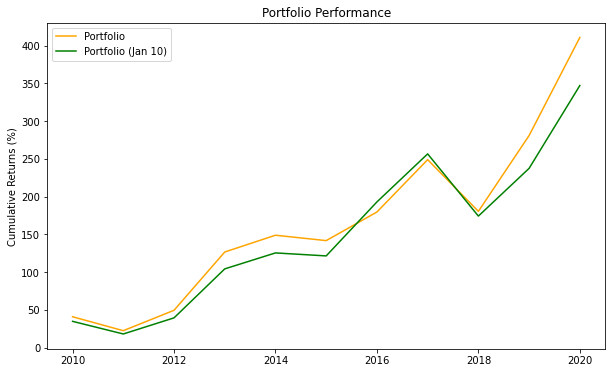

In [13]:
plt.plot(perf['year'],perf['total_port_ret'],label = 'Portfolio',color = 'orange')
plt.plot(perf['year'],perf['total_port_ret10'],label = 'Portfolio (Jan 10)',color = 'green')
plt.legend()
#plt.yscale('log')
plt.ylabel('Cumulative Returns (%)')
plt.title('Portfolio Performance')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.show()

In [14]:
perf

,year,sp_ret,port_ret,port_ret10,1+sp_ret,1+port_ret,1+port_ret10,total_sp_ret,total_port_ret,total_port_ret10,ab_ret,ab_ret10
0,2010.0,0.127827,0.409816,0.348942,1.127827,1.409816,1.348942,12.783,40.982,34.894168,0.281989,0.221115
1,2011.0,-0.000032,-0.130877,-0.123921,0.999968,0.869123,0.876079,12.779,22.530,18.177947,-0.130845,-0.123889
2,2012.0,0.134057,0.220315,0.180448,1.134057,1.220315,1.180448,27.898,49.526,39.502940,0.086258,0.046391
3,2013.0,0.296013,0.516071,0.464875,1.296013,1.516071,1.464875,65.757,126.691,104.354426,0.220058,0.168863
4,2014.0,0.113906,0.098047,0.103425,1.113906,1.098047,1.103425,84.638,148.918,125.489687,-0.015860,-0.010482
5,2015.0,-0.007266,-0.028703,-0.017541,0.992734,0.971297,0.982459,83.297,141.773,121.534441,-0.021437,-0.010275
6,2016.0,0.095350,0.156719,0.322594,1.095350,1.156719,1.322594,100.774,179.663,193.000027,0.061369,0.227243
7,2017.0,0.194200,0.247713,0.217053,1.194200,1.247713,1.217053,139.764,248.940,256.596512,0.053513,0.022853
8,2018.0,-0.062373,-0.196038,-0.230925,0.937627,0.803962,0.769075,124.809,180.534,174.249460,-0.133665,-0.168552
9,2019.0,0.288781,0.357765,0.230474,1.288781,1.357765,1.230474,189.730,280.900,237.456808,0.068985,-0.058307


In [15]:
print('Equal-Weighted Portfolio Return: ', perf["port_ret"].mean())
print('Equal-Weighted Portfolio Return (Jan 10): ', perf["port_ret10"].mean())

Equal-Weighted Portfolio Return:  0.1810616294673876
Equal-Weighted Portfolio Return (Jan 10):  0.16548599028969857


### Export

In [16]:
perf.to_csv('ew_perf.csv')